# Week 3 Exercise: kernel SVM

Advanced Machine Learning for KCS



-------------------------------------------------------------------------------

*The goal is to implement and evaluate different kernels for SVMs for one dataset.*
*We start by importing the necessary libraries.*

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, svm
import pandas as pd
import seaborn as sns

# this code is only for suppressing a very specific warning
import warnings
warnings.filterwarnings('ignore', 'Solver terminated early.*')


#### Creating dataset

We generate our random dataset; this will be 2D data that is not linearly separable. In fact, the data will follow concentric rings.

In [2]:
N = 200 # number of samples
c = 0.5 # scale factor between inner and outer circles
noise = 0.1 # noise parameter

# generate data
x_vals, t_vals = datasets.make_circles(n_samples=N, factor=c, noise=noise)
# if a value in y_vals is 1, we leave it at one, but if it is 0, we set it to -1
t_vals = np.where(t_vals, 1, -1)

class1_idxs = np.flatnonzero(t_vals == 1)
class1_x = x_vals[class1_idxs]
class1_t = t_vals[class1_idxs]
class2_idxs = np.flatnonzero(t_vals == -1)
class2_x = x_vals[class2_idxs]
class2_t = t_vals[class2_idxs]

We can take a quick look at our data to get a sense of what we're trying to predict.

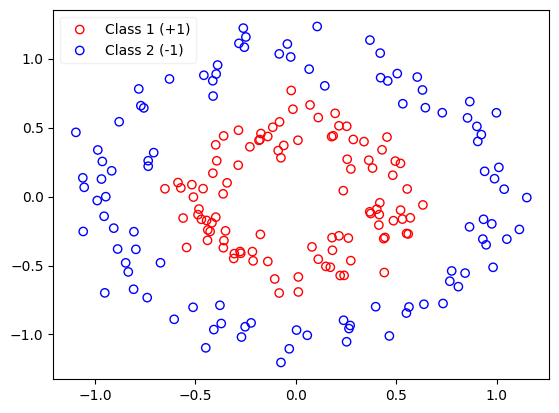

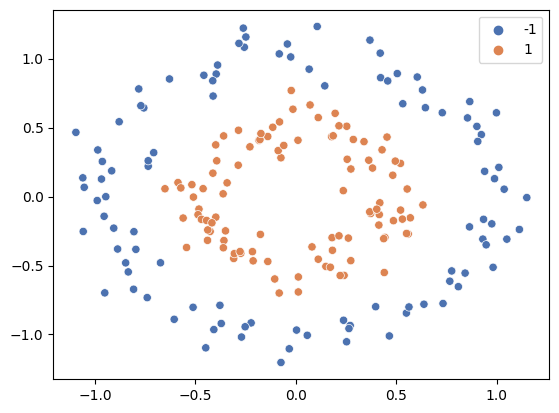

In [3]:
# matplotlib:
plt.scatter(class1_x[:, 0], class1_x[:, 1],
            label = "Class 1 (+1)",
            color = "none",
            edgecolor = "red"
           )
plt.scatter(class2_x[:, 0], class2_x[:, 1],
            label = "Class 2 (-1)",
            color = "none",
            edgecolor = "blue"
           )
plt.legend(loc="upper left", framealpha=0.25)
plt.show()
# simpler with seaborn:
plot_raw = sns.scatterplot(x=x_vals[:,0], y=x_vals[:, 1],
                           hue=t_vals, palette="deep")

## Task:
### (a)
*Implement:*
* *a linear kernel:* $K(\mathbf{x}_1, \mathbf{x}_2) = \mathbf{x}_1^\intercal \mathbf{x}_2$
* *a Gaussian or radial basis function (RBF) kernel:* $K(\mathbf{x}_1, \mathbf{x}_2) = e^{(-\gamma \|\mathbf{x}_1 - \mathbf{x}_2 \|^2)}$
* *a polynomial kernel:* $K(\mathbf{x}_1, \mathbf{x}_2) = (\mathbf{x}_1^\intercal \mathbf{x}_2 + c)^d$

#### Here can can write your solution:

In [109]:
type='gaussian'

import numpy as np

def my_kernel(x, t, kernel_type='linear'):
    # x and t are matrices with shape (n_samples, n_features)
    n_samples_x, n_features_x = x.shape
    n_samples_t, n_features_t = t.shape

    kernel_matrix = np.zeros((n_samples_x, n_samples_t))

    if kernel_type == 'linear':
        # Linear kernel
        kernel_matrix = x @ t.T

    elif kernel_type == 'gaussian':
        gamma = 1.2
        # Gaussian (RBF) kernel
        for i in range(n_samples_x):
            for j in range(n_samples_t):
                squared_distance = np.linalg.norm(x[i] - t[j]) ** 2
                kernel_matrix[i, j] = np.exp(-gamma * squared_distance)

    elif kernel_type == 'polynomial':
        c = 0.005
        d = 2
        kernel_matrix = (x @ t.T + c) ** d

    return kernel_matrix


#### Perform optimisation of the SVM via a manual iteration

https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC.decision_function
We start the training loop for the SVM.  We will randomly choose a batch of points and run the train step.  Then we calculate the loss and accuracy.

In [110]:
# set up the SVM model
# we use max_iter=1 so that we can iterate manually below
clf = svm.SVC(kernel=my_kernel, max_iter=1, tol=0.001, random_state=42)
batch_size = 50 # we start with a batch size equal of the dataset size, but we can try out smaller ones!
epochs = 10000

# training loop
temp_losses = []
batch_accs = []
np.random.seed(0) # set this for your experiments to compare the different kernels
for i in range(epochs):
    # generate random indices equal to batch_size
    batch_idxs = np.random.choice(N, size=batch_size)
    # get the corresponding input and target points
    batch_x = x_vals[batch_idxs]
    batch_t = t_vals[batch_idxs]
    # print(np.shape(batch_x), np.shape(batch_t))

    # train the model with this batch
    clf.fit(batch_x, batch_t)

    # calculate temporary train accuracy
    accuracy = clf.score(batch_x, batch_t)
    batch_accs.append(accuracy)

    if (i+1)%1000==0:
        print("Step #{}".format(i+1))
        print("Accuracy = ", accuracy)

Step #1000
Accuracy =  0.62
Step #2000
Accuracy =  0.86
Step #3000
Accuracy =  0.66
Step #4000
Accuracy =  0.96
Step #5000
Accuracy =  0.64
Step #6000
Accuracy =  0.9
Step #7000
Accuracy =  0.92
Step #8000
Accuracy =  0.74
Step #9000
Accuracy =  0.82
Step #10000
Accuracy =  0.78


*To plot a pretty picture of the regions we fit, we create a fine mesh to run through our model and get the predictions.*

In [107]:
# find boundaries for contour plot
abscissa_min, abscissa_max = x_vals[:, 0].min()-1, x_vals[:, 0].max()+1
ordinate_min, ordinate_max = x_vals[:, 1].min()-1, x_vals[:, 1].max()+1

# generate mesh grid of points
#h = .025  # step size in the mesh
#xx, yy = np.meshgrid(np.arange(abscissa_min, abscissa_max, h), np.arange(ordinate_min, ordinate_max, h))
xx, yy = np.meshgrid(
    np.linspace(abscissa_min, abscissa_max, 10),
    np.linspace(ordinate_min, ordinate_max, 20)
)

grid_points = np.c_[xx.ravel(), yy.ravel()]
print(np.shape(grid_points))

print(xx)
print(yy)
grid_preds = clf.predict(grid_points)  # this is not a clean way to do and will raise a warning (we only process values here, but trained with dataframes that had names), but for our purpose that's fine
grid_preds = grid_preds.reshape(xx.shape)


(200, 2)
[[-2.21113463 -1.7356966  -1.26025858 -0.78482055 -0.30938252  0.16605551
   0.64149354  1.11693157  1.5923696   2.06780763]
 [-2.21113463 -1.7356966  -1.26025858 -0.78482055 -0.30938252  0.16605551
   0.64149354  1.11693157  1.5923696   2.06780763]
 [-2.21113463 -1.7356966  -1.26025858 -0.78482055 -0.30938252  0.16605551
   0.64149354  1.11693157  1.5923696   2.06780763]
 [-2.21113463 -1.7356966  -1.26025858 -0.78482055 -0.30938252  0.16605551
   0.64149354  1.11693157  1.5923696   2.06780763]
 [-2.21113463 -1.7356966  -1.26025858 -0.78482055 -0.30938252  0.16605551
   0.64149354  1.11693157  1.5923696   2.06780763]
 [-2.21113463 -1.7356966  -1.26025858 -0.78482055 -0.30938252  0.16605551
   0.64149354  1.11693157  1.5923696   2.06780763]
 [-2.21113463 -1.7356966  -1.26025858 -0.78482055 -0.30938252  0.16605551
   0.64149354  1.11693157  1.5923696   2.06780763]
 [-2.21113463 -1.7356966  -1.26025858 -0.78482055 -0.30938252  0.16605551
   0.64149354  1.11693157  1.5923696   2.0

*Then we make the plot of our points and our decision boundary.*

c:\Users\rvacher\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


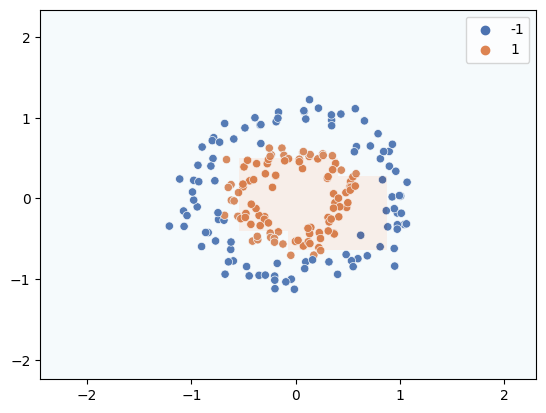

In [108]:
plot_rsk = sns.scatterplot(x=x_vals[:,0], y=x_vals[:,1],
                           hue=t_vals, cmap=plt.cm.Paired, palette="deep")
plot_rsk.pcolormesh(xx, yy, grid_preds, cmap=plt.cm.Paired, alpha=0.1)

We can also plot the accuracy over the training batches:

<Axes: xlabel='Batch', ylabel='Accuracy'>

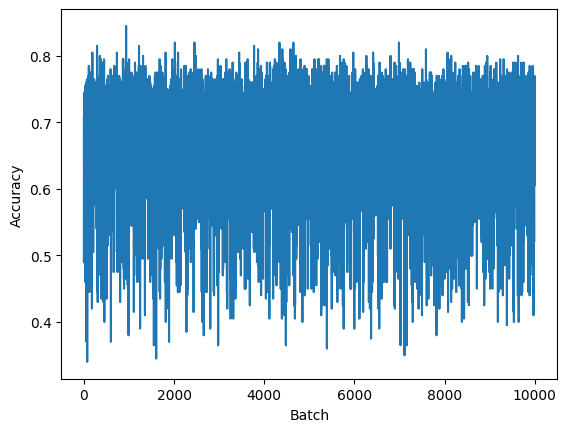

In [84]:
batch_accs_pd = pd.DataFrame({'Batch': [k for k in range(len(batch_accs))], 'Accuracy': batch_accs})
sns.lineplot(data=batch_accs_pd, x="Batch", y="Accuracy")

## Task:
### (b)
*Which of these performs best on the data, in terms of speed and quality? Do not forget to set the random seed to receive reproducible results.*

- Linear:
    - acc = 0.49
    - batch = N
    - sPEED = 20s
- gauss:
    - acc = 0.44
    - batch = 50
    - gA = 0.2
    - spEED = 8m
- poly:
    - acc = 0.695
    - c , d = .2, 2
    - batch = N
    - speeD = 28

### (c)
*Test different values of $c$ and $d$ for the polynomial kernel. Which of them work best?*

- c,d = .2, 2
- acc = 0.695

- c,d = .3, 2
- acc = 0.68

- c,d = .5, 1
- acc = 0.49

- c,d = .2, 5
- acc = 0.53

- c,d = .005, 2
- acc = 0.62

### (d)
*Test different values of $\gamma$ for the RBF kernel. Which of them works best?*

- g = 0.2
- acc = .44

- g = 1
- acc = 0.76

- g = 1.2
- acc = 0.78

### (e)
*Change the part of the code which generates the data such that it becomes linearly separable.*

In [2]:
N = 200 # number of samples
c = 0.5 # scale factor between inner and outer circles
noise = 0.1 # noise parameter

# generate data
x_vals, t_vals = datasets.make_classification(N, class_sep= 2000000, n_clusters_per_class=1, n_redundant= 0, n_classes= 2, n_informative= 4)
# if a value in y_vals is 1, we leave it at one, but if it is 0, we set it to -1
t_vals = np.where(t_vals, 1, -1)

class1_idxs = np.flatnonzero(t_vals == 1)
class1_x = x_vals[class1_idxs]
class1_t = t_vals[class1_idxs]
class2_idxs = np.flatnonzero(t_vals == -1)
class2_x = x_vals[class2_idxs]
class2_t = t_vals[class2_idxs]

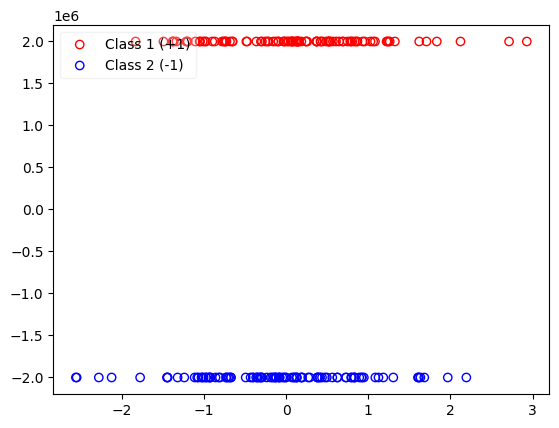

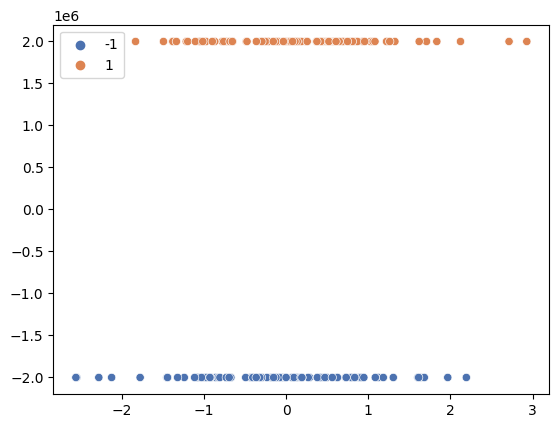

In [3]:
# matplotlib:
plt.scatter(class1_x[:, 0], class1_x[:, 1],
            label = "Class 1 (+1)",
            color = "none",
            edgecolor = "red"
           )
plt.scatter(class2_x[:, 0], class2_x[:, 1],
            label = "Class 2 (-1)",
            color = "none",
            edgecolor = "blue"
           )
plt.legend(loc="upper left", framealpha=0.25)
plt.show()
# simpler with seaborn:
plot_raw = sns.scatterplot(x=x_vals[:,0], y=x_vals[:, 1],
                           hue=t_vals, palette="deep")

### (f)
*Re-evaluate the three kernels. Do you get the same result?*

In [19]:
type='gaussian'

import numpy as np

def my_kernel(x, t, kernel_type='linear'):
    # x and t are matrices with shape (n_samples, n_features)
    n_samples_x, n_features_x = x.shape
    n_samples_t, n_features_t = t.shape

    kernel_matrix = np.zeros((n_samples_x, n_samples_t))

    if kernel_type == 'linear':
        # Linear kernel
        kernel_matrix = x @ t.T

    elif kernel_type == 'gaussian':
        gamma = 1
        # Gaussian (RBF) kernel
        for i in range(n_samples_x):
            for j in range(n_samples_t):
                squared_distance = np.linalg.norm(x[i] - t[j]) ** 2
                kernel_matrix[i, j] = np.exp(-gamma * squared_distance)

    elif kernel_type == 'polynomial':
        c = 0.2
        d = 2
        kernel_matrix = (x @ t.T + c) ** d

    return kernel_matrix


In [4]:
# Define the loop function to return only the final performance
def evaluate_with_kernels(x_vals, t_vals, kernel_types=['linear', 'polynomial', 'gaussian'], batch_size=200, epochs=10000):
    results = {}
    
    for kernel_type in kernel_types:
        print(f"Evaluating with {kernel_type} kernel...")
        def my_kernel(x, t, kernel_type=kernel_type):
            # x and t are matrices with shape (n_samples, n_features)
            n_samples_x, n_features_x = x.shape
            n_samples_t, n_features_t = t.shape

            kernel_matrix = np.zeros((n_samples_x, n_samples_t))

            if kernel_type == 'linear':
                # Linear kernel
                kernel_matrix = x @ t.T

            elif kernel_type == 'gaussian':
                gamma = 1
                # Gaussian (RBF) kernel
                for i in range(n_samples_x):
                    for j in range(n_samples_t):
                        squared_distance = np.linalg.norm(x[i] - t[j]) ** 2
                        kernel_matrix[i, j] = np.exp(-gamma * squared_distance)

            elif kernel_type == 'polynomial':
                c = 0.2
                d = 2
                kernel_matrix = (x @ t.T + c) ** d

            return kernel_matrix
        
        clf = svm.SVC(kernel=my_kernel, max_iter=1, tol=0.001, random_state=42)

        temp_losses = []
        batch_accs = []
        np.random.seed(0)

        for i in range(epochs):
            batch_idxs = np.random.choice(len(x_vals), size=batch_size)
            batch_x = x_vals[batch_idxs]
            batch_t = t_vals[batch_idxs]

            clf.fit(batch_x, batch_t)

            accuracy = clf.score(batch_x, batch_t)
            batch_accs.append(accuracy)

            if (i+1) % 1000 == 0:
                print("Step #{}".format(i+1))
                print("Accuracy = ", accuracy)

        # Calculate the final accuracy and store it
        final_accuracy = batch_accs[-1]
        results[kernel_type] = final_accuracy

    return results
evaluate_with_kernels(x_vals, t_vals)

Evaluating with linear kernel...
Step #1000
Accuracy =  1.0
Step #2000
Accuracy =  1.0
Step #3000
Accuracy =  1.0
Step #4000
Accuracy =  1.0
Step #5000
Accuracy =  1.0
Step #6000
Accuracy =  1.0
Step #7000
Accuracy =  1.0
Step #8000
Accuracy =  1.0
Step #9000
Accuracy =  1.0
Step #10000
Accuracy =  1.0
Evaluating with polynomial kernel...
Step #1000
Accuracy =  0.525
Step #2000
Accuracy =  0.52
Step #3000
Accuracy =  0.54
Step #4000
Accuracy =  0.445
Step #5000
Accuracy =  0.515
Step #6000
Accuracy =  0.465
Step #7000
Accuracy =  0.55
Step #8000
Accuracy =  0.505
Step #9000
Accuracy =  0.51
Step #10000
Accuracy =  0.48
Evaluating with gaussian kernel...
Step #1000
Accuracy =  1.0
Step #2000
Accuracy =  1.0
Step #3000
Accuracy =  1.0
Step #4000
Accuracy =  1.0
Step #5000
Accuracy =  1.0
Step #6000
Accuracy =  1.0
Step #7000
Accuracy =  1.0
Step #8000
Accuracy =  1.0
Step #9000
Accuracy =  1.0
Step #10000
Accuracy =  1.0


{'linear': 1.0, 'polynomial': 0.48, 'gaussian': 1.0}